# Overview

This notebook contains a detailed approach of different classifiaction models used to classify or predict whether a customer who is granted a loan, will pay the loan or the loan will be in collection(default).

There are two datasets used here, one for training the model and validating the model and other to test the model.

Finally the accuracies of the different models used are reported in a pandas dataframe using different evaluation metrices

The different models used here are:
1. **K Nearest Neighbors**
2. **Decision Tree**
3. **Support Vector Machine**
4. **Logistic Regression**

The intention is to check which model will be the best fit to predict the outcomes from an unknown data set

# Importing Libraries

In [153]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
from sklearn.metrics import accuracy_score


### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off or in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets load the dataset

### Load Data From CSV File  

In [154]:
df = pd.read_csv(r'C:\Users\hp world\Downloads\loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [155]:
df.shape

(346, 10)

### Convert to date time object 

In [156]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [157]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         156 KB  anaconda
    seaborn-0.9.0              |           py36_0         379 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    ca-certificates-2019.5.15  |                1         134 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.7 MB

The following packages will be UPDATED:

    ca-certificates: 2019.5.15-1       --> 2019.5.15-1      anaconda
    certifi:         2019.6.16-py36_1  --> 2019.6.16-py36_1 anaconda
    openssl:         1.1.1d-h7b6447c_1 --> 1.1.1-h7b6447c_0 anaconda
    seaborn:         0.9.0-py36_0     

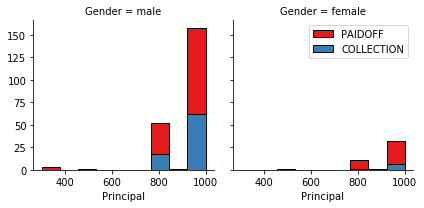

In [158]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

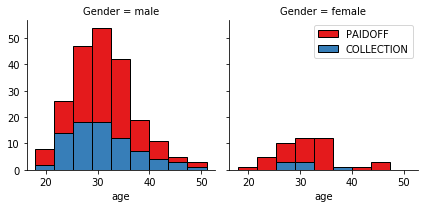

In [159]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

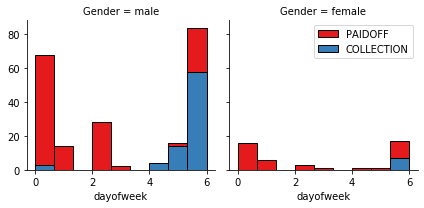

In [160]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [161]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [162]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [163]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  


In [164]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [165]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Using one hot encoding technique to convert categorical varables to binary variables and appending them to the feature Data Frame 

In [166]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [167]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


our lables

In [168]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

In [169]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is the turn,to use the training set to build an accurate model. Then using the test set to report the accuracy of the model
I will use the following algorithms:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression





# K Nearest Neighbor(KNN)


In [170]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=4)
print('Train Set:', X_train.shape, y_train.shape)
print('Test Set:', X_test.shape, y_test.shape)

Train Set: (242, 8) (242,)
Test Set: (104, 8) (104,)


In [171]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.71153846, 0.625     , 0.72115385, 0.72115385, 0.73076923,
       0.71153846, 0.72115385, 0.72115385, 0.75      , 0.68269231,
       0.69230769, 0.71153846, 0.71153846, 0.72115385, 0.71153846,
       0.71153846, 0.72115385, 0.69230769, 0.70192308, 0.69230769,
       0.75      , 0.72115385, 0.73076923, 0.71153846, 0.73076923,
       0.73076923, 0.74038462, 0.75      , 0.74038462])

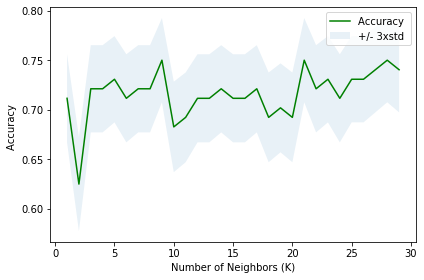

In [172]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [174]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.75 with k= 9


In [175]:
K = 9
neigh1 = KNeighborsClassifier(n_neighbors = K).fit(X_train,y_train)
neigh1
yhat1 = neigh1.predict(X_test)

In [176]:
accuracy_score(y_test,yhat1)

0.75

# Decision Tree

In [177]:
from sklearn.tree import DecisionTreeClassifier
Ds = 30
mean_acc = np.zeros((Ds-1))
std_acc = np.zeros((Ds-1))
ConfustionMx = [];
for n in range(1,Ds):
    
    #Train Model and Predict  
    Dectree = DecisionTreeClassifier(max_depth = n).fit(X_train,y_train)
    Dectree_pred=Dectree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, Dectree_pred)

    
    std_acc[n-1]=np.std(Dectree_pred==y_test)/np.sqrt(Dectree_pred.shape[0])

mean_acc

array([0.74038462, 0.74038462, 0.74038462, 0.74038462, 0.75961538,
       0.75961538, 0.74038462, 0.71153846, 0.66346154, 0.67307692,
       0.67307692, 0.65384615, 0.70192308, 0.67307692, 0.68269231,
       0.72115385, 0.71153846, 0.71153846, 0.71153846, 0.70192308,
       0.71153846, 0.71153846, 0.71153846, 0.70192308, 0.70192308,
       0.70192308, 0.70192308, 0.70192308, 0.71153846])

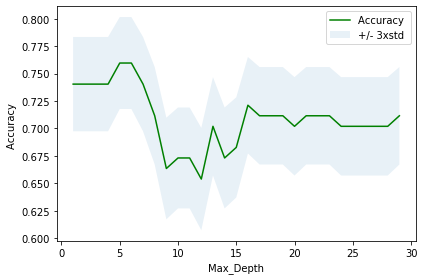

In [178]:
plt.plot(range(1,Ds),mean_acc,'g')
plt.fill_between(range(1,Ds),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Max_Depth')
plt.tight_layout()
plt.show()

In [179]:
print( "The best accuracy was with", mean_acc.max(), "with max_depth=", mean_acc.argmax()+1) 

The best accuracy was with 0.7596153846153846 with max_depth= 5


In [180]:
from sklearn.tree import DecisionTreeClassifier
x = 5
Dectree2 = DecisionTreeClassifier(max_depth = x)
Dectree2.fit(X_train, y_train)
Dectree2_pred = Dectree2.predict(X_test)

In [181]:
accuracy_score(y_test,Dectree2_pred)

0.7596153846153846

# Support Vector Machine

In [182]:
from sklearn import svm
support = svm.SVC(kernel='rbf')
support.fit(X_train, y_train) 

C:\Users\hp world\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [183]:
support_pred = support.predict(X_test)

In [184]:
accuracy_score(y_test,support_pred)

0.75

# Logistic Regression

In [185]:
from sklearn.linear_model import LogisticRegression
logis = LogisticRegression(solver = 'liblinear')
logis.fit(X_train,y_train)
logis_predict = logis.predict(X_test)

In [186]:
accuracy_score(y_test,logis_predict)

0.7211538461538461

# Model Evaluation using Test set

In [187]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First,  load the test set:

### Load Test set for evaluation 

In [188]:
test_df = pd.read_csv(r'C:\Users\hp world\Downloads\loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


#  Pre-processing:  Feature selection/extraction for Test Set

In [189]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

Here we get the test data set ready for prediction

Almost the similar steps are taken to do so as the feature set which we will feed the developed models hae to be same as the one of the training data set

In [190]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [191]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [192]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

### Replacing the Gender with values of 0 and 1

In [193]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [194]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

### One Hot Encoding on the test data set

In [195]:
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


#### Specifying the feature set 

In [196]:
M = Feature_test

In [197]:
Feature_test.shape

(54, 8)

In [198]:
n = test_df['loan_status'].values
n[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [199]:
n.shape

(54,)

# Normalize Data

In [200]:
M= preprocessing.StandardScaler().fit(M).transform(M)
M[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

# Pediction Using the  Different Developed Models

##### Using KNN

In [201]:
KNN = neigh1.predict(M)

##### Using Decision Tree

In [202]:
Decision = Dectree2.predict(M)

##### Using Support Vector Machine

In [203]:
Vector = support.predict(M) 

##### Using Logisitic Regression

In [204]:
Logistic = logis.predict(M)


Finding the probability of the predictions in using the **Logistic Regression** model

In [235]:
Logistic_prob = logis.predict_proba(M)
Logistic_prob[0:5]


array([[0.00906901, 0.99093099],
       [0.3031468 , 0.6968532 ],
       [0.22866629, 0.77133371],
       [0.48564066, 0.51435934],
       [0.40834369, 0.59165631]])

## Jaccard_Similarity_Score for the different predictions

In [217]:
j1 = jaccard_similarity_score(n,KNN)

C:\Users\hp world\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [218]:
j2 = jaccard_similarity_score(n,Decision)

C:\Users\hp world\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [219]:
j3 = jaccard_similarity_score(n,Vector)

C:\Users\hp world\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [220]:
j4 = jaccard_similarity_score(n,Logistic)

C:\Users\hp world\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


## f1_scores for the different models

In [221]:
F1 = f1_score(n,KNN,pos_label='PAIDOFF')

In [222]:
F2 = f1_score(n,Decision,pos_label='PAIDOFF')

In [223]:
F3 = f1_score(n,Vector,pos_label='PAIDOFF')

In [224]:
F4 = f1_score(n,Logistic,pos_label='PAIDOFF')

## Log Loss for Logistic Regression

It is important to notice that log loss doesnot take string values and takes the probabilities of the outcomes of the binary class in the target variables which was calculated previously and stored in the variable **Logisitic_prob**

In [225]:
L1 =log_loss(n,Logistic_prob)

# Report
The format to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [233]:
Report = pd.DataFrame({'Algorithm':['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'], 
                   'Jaccard':[j1,j2,j3,j4], 
                   'F1-score':[F1,F2,F3,F4],
                   'LogLoss': ['NA', 'NA', 'NA', L1]}) 

Below a report of the diffferent **Evaluation Metices** for the different algorithms used is provided

In [234]:
Report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.666667,0.795455,NA
1,Decision Tree,0.777778,0.869565,NA
2,SVM,0.740741,0.851064,NA
3,LogisticRegression,0.759259,0.860215,0.471908


So here we can draw get an understanding of which model will be the best suite for the classification problem in hand by seeing the report above. From my understanding , going by the report I will choose the **Decision Tree** model.